# PHY294 Franck-Hertz Experiment
### This notebook will plot the experimental data, find the line of best fit, and calculate goodness of fit criterion

#### Imports

In [103]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

#### Read in data to pandas df

In [104]:
file_paths = glob.glob('/Users/lucaschoi/Documents/GitHub/PHY294-Franck-Hertz/data/*.csv')
dataframes = {}
E2_voltages = []

for path in file_paths:
    if 'old' not in path:
        voltage = path.split('/')[-1].replace('.csv', '')
        data = pd.read_csv(path)
        dataframes[float(voltage)] = data
        E2_voltages.append(float(voltage))

E2_voltages = sorted(E2_voltages)

### Plot the different trials

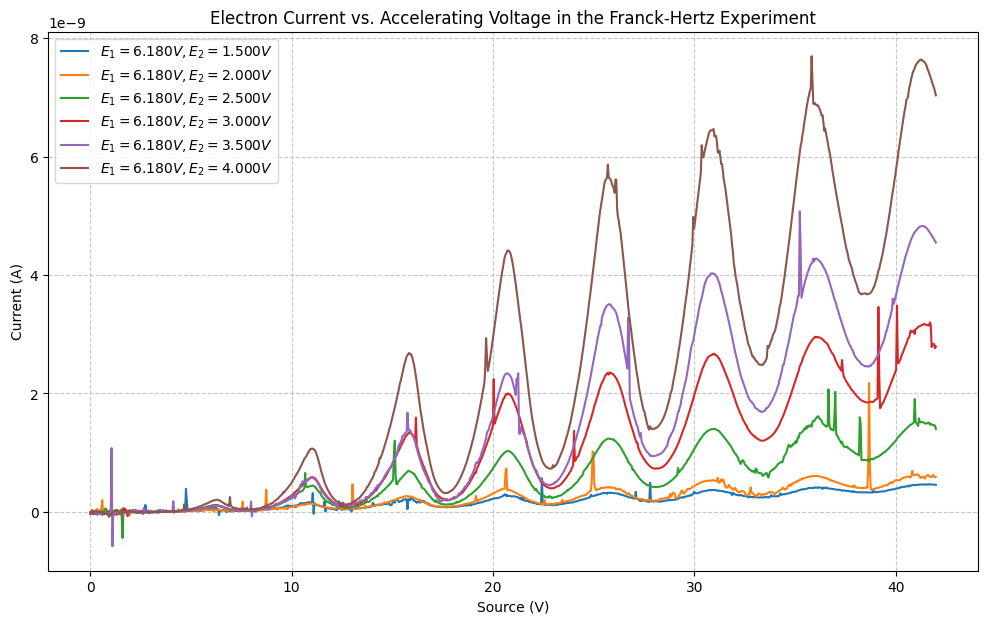

In [105]:
legend = []
plt.figure(figsize=(12, 7))
for voltage in E2_voltages:

    data = dataframes[voltage]
    plt.plot(data['CH2 Voltage'], data['CH1 Current'], label=f'$E_1= 6.180 V, E_2 = {voltage:.3f} V$')

plt.xlabel('Source (V)')
plt.ylabel('Current (A)')
plt.title('Electron Current vs. Accelerating Voltage in the Franck-Hertz Experiment')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

### From here forward, we choose to use the $E_2 = 4.000V$ data since the peaks are the best defined

### Find peaks

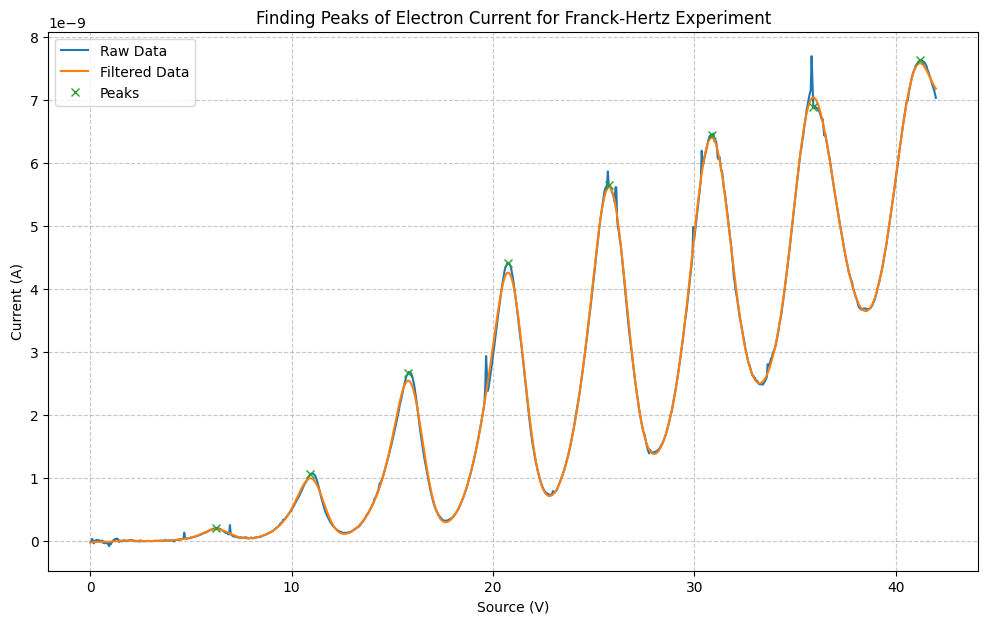

[149 260 376 494 613 735 855 981]


In [106]:
x = dataframes[4.0]['CH2 Voltage']
y = dataframes[4.0]['CH1 Current']

# apply a bandpass filter
b, a = signal.butter(3, 0.05)
y_filtered = signal.filtfilt(b, a, y)

peaks, _ = signal.find_peaks(y_filtered, height=0.00000000001)

plt.figure(figsize=(12, 7))
plt.plot(x, y, label='Raw Data')
plt.plot(x, y_filtered, label='Filtered Data')
plt.plot(x[peaks], y[peaks], 'x', label='Peaks')
plt.xlabel('Source (V)')
plt.ylabel('Current (A)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Finding Peaks of Electron Current for Franck-Hertz Experiment')
plt.show()
print(peaks)

